# Task 2: Hyperelasticity



In [2]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib


### Data import

In [3]:
import random

# 假设有 100 个文件
file_list = [f"../../concentric/{i}.txt" for i in range(1, 100)]

# 确保随机选择可复现
random.seed(42)

# 按 70% 校准集，30% 测试集划分
calibration_files_4 = random.sample(file_list, 16)
calibration_files_5 = random.sample(file_list, 32)
calibration_files_6 = random.sample(file_list, 64)
calibration_files_658 = random.sample(file_list, 96)
#test_files = [f for f in file_list if f not in calibration_files]

# 打印划分结果
#print(f"Calibration files: {len(calibration_files)}")
#print(f"Test files: {len(test_files)}")

#print("Calibration set example:", calibration_files[:5])
#print("Test set example:", test_files[:5])

In [4]:
used_files = set(calibration_files_4 + calibration_files_5 + calibration_files_6 + calibration_files_658)
remaining_files = list(set(file_list) - used_files)
test_files = random.sample(remaining_files, 1) 
print(f"Test files: {test_files}")

Test files: ['../../concentric/40.txt']


In [5]:
import numpy as np
data_list = []
for file in calibration_files_4:
    data = np.loadtxt(file)  
    data_list.append(data)
F_train_4 = np.concatenate(data_list, axis=0).reshape(-1, 3, 3)    
print(F_train_4.shape)

(800, 3, 3)


In [6]:
data_list = []
for file in calibration_files_5:
    data = np.loadtxt(file)  
    data_list.append(data)
F_train_5 = np.concatenate(data_list, axis=0).reshape(-1, 3, 3)    
print(F_train_5.shape)

(1600, 3, 3)


In [7]:
data_list = []
for file in calibration_files_6:
    data = np.loadtxt(file)  
    data_list.append(data)
F_train_6 = np.concatenate(data_list, axis=0).reshape(-1, 3, 3)
print(F_train_6.shape)

(3200, 3, 3)


In [8]:
data_list = []
for file in calibration_files_658:
    data = np.loadtxt(file)  
    data_list.append(data)
F_train_658 = np.concatenate(data_list, axis=0).reshape(-1, 3, 3)
print(F_train_658.shape)


(4800, 3, 3)


In [9]:
import numpy as np
data_list = []
for file in test_files:
    data = np.loadtxt(file)  
    data_list.append(data.reshape(-1, 3, 3))
F_test = np.concatenate(data_list, axis=0)    
print(F_test.shape)

(50, 3, 3)


In [10]:
import numpy as np

import tensorflow as tf

def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    # F shape is (batch_size, 3, 3)
    batch_size = tf.shape(F)[0]
    
    # 计算右 Cauchy-Green 张量 C = F^T * F
    # Using einsum for batch matrix multiplication
    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = tf.linalg.trace(C)  # shape: (batch_size,)
    
    # For I2, compute trace(C@C) with batch operation
    C_square = tf.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - tf.linalg.trace(C_square))  # shape: (batch_size,)
    
    # Compute determinant for each matrix in the batch
    J = tf.linalg.det(F)  # shape: (batch_size,)
    
    # 定义结构张量 Gti
    Gti = tf.constant([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ], dtype=tf.float32)
    
    # 扩展 Gti 到批量维度
    Gti = tf.tile(Gti[None, :, :], [batch_size, 1, 1])
    
    # 计算不变量 I4
    I4 = tf.linalg.trace(tf.einsum('bij,bjk->bik', C, Gti))  # shape: (batch_size,)
    
    # 计算 C 的余因子（Cofactor）
    # First compute inverse of C for each matrix in batch
    I3 = tf.linalg.det(C)

# 使用 I3 和 C 的逆计算 Cofactor 矩阵
    Cof_C = I3[:, None, None] * tf.linalg.inv(C)

    # 计算不变量 I5
    I5 = tf.linalg.trace(tf.einsum('bij,bjk->bik', Cof_C, Gti))  # shape: (batch_size,)
    
    return I1, J, I4, I5

In [11]:
#@tf.function
def neo_hookean_potential(I1, J, I4, I5):
    # 计算应变能密度 W
    W = 8 * I1 + 10 * (J ** 2) - 56 * tf.math.log(J) + 0.2 * (I4 ** 2 + I5 ** 2) - 44
    return W


In [12]:
# 计算应力张量 P
def compute_stress_tensor(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(F)
        
        # 计算不变量 I1, J, I4 和 I5
        I1, J, I4, I5 = compute_invariants(F)
        
        # 计算应变能函数 W
        W = neo_hookean_potential(I1, J, I4, I5)
    
    # 使用自动微分计算应力张量 P = dW/dF
    #print("W shape:", W.shape)
    P = tape.gradient(W, F)
    return P

### Naive model B1

In [17]:
import models_naive_B1 as lm_naive_B1
model_naive_B1 = lm_naive_B1.main()

model_naive_B1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 private_c_to_p (_C_to_P)    (None, 9)                 537       
                                                                 
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [78]:
# 训练模型
def convert_F_to_C(F_data):
    # 将 F_data 重塑为 (N, 3, 3) 形状
    F_data = F_data.reshape(-1, 3, 3)
    # 对每个样本计算 C = F^T * F
    C_data = np.einsum('...ji,...jk->...ik', F_data, F_data)
    # 提取对称矩阵 C 的六个独立分量
    C_data_6 = np.stack([C_data[:, 0, 0],  # c11
                         C_data[:, 1, 1],  # c22
                         C_data[:, 2, 2],  # c33
                         C_data[:, 0, 1],  # c12
                         C_data[:, 0, 2],  # c13
                         C_data[:, 1, 2]], axis=-1)  # c23
    return C_data_6

# 转换训练和测试数据
C_train_4 = convert_F_to_C(F_train_4)
C_train_5 = convert_F_to_C(F_train_5)
C_train_6 = convert_F_to_C(F_train_6)
C_train_658 = convert_F_to_C(F_train_658)
C_test = convert_F_to_C(F_test)


P_train_tensor_4 = compute_stress_tensor(F_train_4)
P_train_tensor_5 = compute_stress_tensor(F_train_5)
P_train_tensor_6 = compute_stress_tensor(F_train_6)
P_train_tensor_658 = compute_stress_tensor(F_train_658)
P_test_tensor = compute_stress_tensor(F_test)

P_train_4 = P_train_tensor_4.numpy().reshape(-1,9)
P_train_5 = P_train_tensor_5.numpy().reshape(-1,9)
P_train_6 = P_train_tensor_6.numpy().reshape(-1,9)
P_train_658 = P_train_tensor_658.numpy().reshape(-1,9)
P_test = P_test_tensor.numpy().reshape(-1,9)




Epoch 1/2500
25/25 [==============================] - 1s 7ms/step - loss: 486.1808 - val_loss: 215.3221
Epoch 2/2500
25/25 [==============================] - 0s 2ms/step - loss: 480.8916 - val_loss: 211.8656
Epoch 3/2500
25/25 [==============================] - 0s 2ms/step - loss: 475.1846 - val_loss: 208.4686
Epoch 4/2500
25/25 [==============================] - 0s 2ms/step - loss: 468.2216 - val_loss: 203.8922
Epoch 5/2500
25/25 [==============================] - 0s 2ms/step - loss: 459.3457 - val_loss: 198.9600
Epoch 6/2500
25/25 [==============================] - 0s 2ms/step - loss: 448.9892 - val_loss: 193.3415
Epoch 7/2500
25/25 [==============================] - 0s 2ms/step - loss: 438.8357 - val_loss: 192.2190
Epoch 8/2500
25/25 [==============================] - 0s 2ms/step - loss: 430.3933 - val_loss: 197.3250
Epoch 9/2500
25/25 [==============================] - 0s 2ms/step - loss: 423.5926 - val_loss: 198.1749
Epoch 10/2500
25/25 [==============================] - 0s 2ms/st

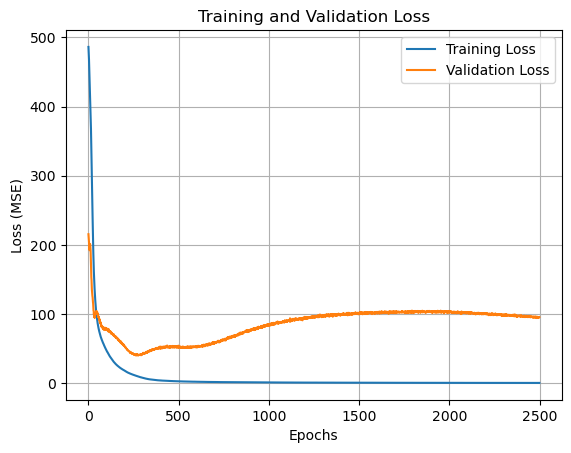

In [19]:
model_naive_B1_4 = model_naive_B1
history = model_naive_B1_4.fit(C_train_4, P_train_4, epochs=2500, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()
finalLoss_naive_B1_4 = history.history['loss'][-1]
finalValLoss_naive_B1_4 = history.history['val_loss'][-1]


Epoch 1/2500
50/50 [==============================] - 0s 2ms/step - loss: 88.9221 - val_loss: 48.3935
Epoch 2/2500
50/50 [==============================] - 0s 1ms/step - loss: 58.7162 - val_loss: 54.8407
Epoch 3/2500
50/50 [==============================] - 0s 1ms/step - loss: 49.8922 - val_loss: 53.4117
Epoch 4/2500
50/50 [==============================] - 0s 2ms/step - loss: 44.7805 - val_loss: 47.6679
Epoch 5/2500
50/50 [==============================] - 0s 2ms/step - loss: 40.7005 - val_loss: 43.4041
Epoch 6/2500
50/50 [==============================] - 0s 1ms/step - loss: 37.9229 - val_loss: 44.2582
Epoch 7/2500
50/50 [==============================] - 0s 2ms/step - loss: 35.6833 - val_loss: 40.4116
Epoch 8/2500
50/50 [==============================] - 0s 2ms/step - loss: 33.8867 - val_loss: 35.9287
Epoch 9/2500
50/50 [==============================] - 0s 1ms/step - loss: 32.4762 - val_loss: 36.3678
Epoch 10/2500
50/50 [==============================] - 0s 2ms/step - loss: 31.1215

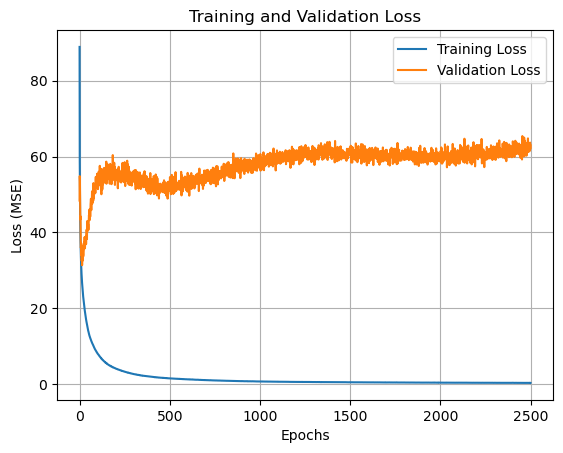

In [20]:
model_naive_B1_5 = model_naive_B1
history = model_naive_B1_5.fit(C_train_5, P_train_5, epochs=2500, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()
finalLoss_naive_B1_5 = history.history['loss'][-1]
finalValLoss_naive_B1_5 = history.history['val_loss'][-1]

Epoch 1/2500
100/100 [==============================] - 0s 2ms/step - loss: 32.8600 - val_loss: 43.0937
Epoch 2/2500
100/100 [==============================] - 0s 1ms/step - loss: 23.4510 - val_loss: 37.9927
Epoch 3/2500
100/100 [==============================] - 0s 1ms/step - loss: 20.5522 - val_loss: 40.9748
Epoch 4/2500
100/100 [==============================] - 0s 1ms/step - loss: 18.6663 - val_loss: 51.4785
Epoch 5/2500
100/100 [==============================] - 0s 1ms/step - loss: 17.5414 - val_loss: 41.9109
Epoch 6/2500
100/100 [==============================] - 0s 1ms/step - loss: 16.5376 - val_loss: 41.9258
Epoch 7/2500
100/100 [==============================] - 0s 1ms/step - loss: 15.5753 - val_loss: 44.0237
Epoch 8/2500
100/100 [==============================] - 0s 1ms/step - loss: 14.9524 - val_loss: 45.5654
Epoch 9/2500
100/100 [==============================] - 0s 1ms/step - loss: 14.2641 - val_loss: 40.3071
Epoch 10/2500
100/100 [==============================] - 0s 1ms/

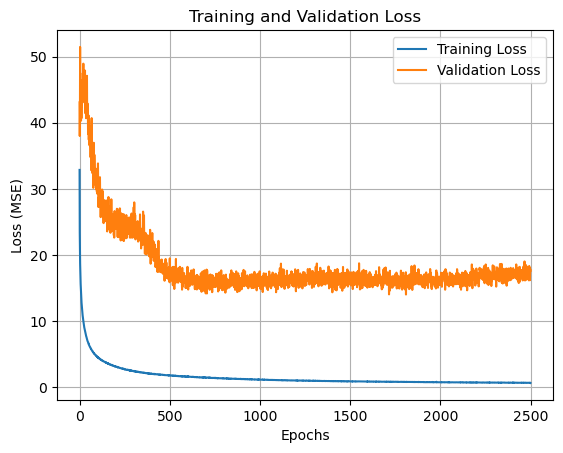

In [21]:
model_naive_B1_6 = model_naive_B1
history = model_naive_B1_6.fit(C_train_6, P_train_6, epochs=2500, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()
finalLoss_naive_B1_6 = history.history['loss'][-1]
finalValLoss_naive_B1_6 = history.history['val_loss'][-1]

Epoch 1/2500
150/150 [==============================] - 0s 2ms/step - loss: 4.6330 - val_loss: 17.5359
Epoch 2/2500
150/150 [==============================] - 0s 1ms/step - loss: 3.8317 - val_loss: 16.2842
Epoch 3/2500
150/150 [==============================] - 0s 1ms/step - loss: 3.6714 - val_loss: 17.6490
Epoch 4/2500
150/150 [==============================] - 0s 1ms/step - loss: 3.5185 - val_loss: 17.3233
Epoch 5/2500
150/150 [==============================] - 0s 1ms/step - loss: 3.3822 - val_loss: 17.0989
Epoch 6/2500
150/150 [==============================] - 0s 1ms/step - loss: 3.3760 - val_loss: 18.2741
Epoch 7/2500
150/150 [==============================] - 0s 1ms/step - loss: 3.2358 - val_loss: 20.3554
Epoch 8/2500
150/150 [==============================] - 0s 1ms/step - loss: 3.1676 - val_loss: 16.4111
Epoch 9/2500
150/150 [==============================] - 0s 1ms/step - loss: 3.0744 - val_loss: 14.8505
Epoch 10/2500
150/150 [==============================] - 0s 1ms/step - lo

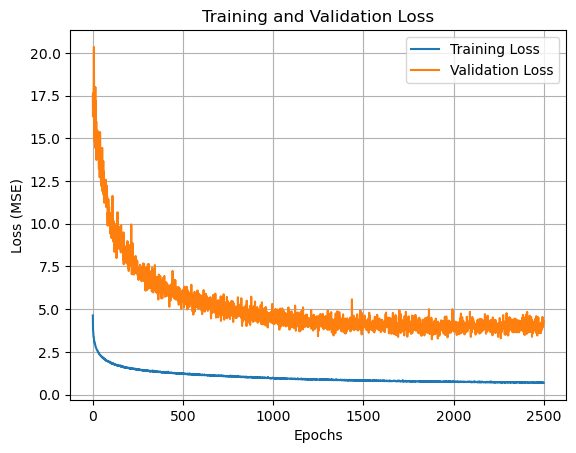

In [22]:
model_naive_B1_658 = model_naive_B1
history = model_naive_B1_658.fit(C_train_658, P_train_658, epochs=2500, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()
finalLoss_naive_B1_658 = history.history['loss'][-1]
finalValLoss_naive_B1_658 = history.history['val_loss'][-1]

### Naive model B2

In [68]:
import models_naive_B2 as lm_naive_B2
model_naive_B2 = lm_naive_B2.main()

model_naive_B2.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 6)]               0         
                                                                 
 private_c_to_p (_C_to_P)    (None, 9)                 13513     
                                                                 
Total params: 13,513
Trainable params: 13,513
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
25/25 [==============================] - 0s 6ms/step - loss: 472.4396 - val_loss: 199.8714
Epoch 2/2500
25/25 [==============================] - 0s 2ms/step - loss: 441.3441 - val_loss: 208.4986
Epoch 3/2500
25/25 [==============================] - 0s 2ms/step - loss: 434.9659 - val_loss: 219.4354
Epoch 4/2500
25/25 [==============================] - 0s 2ms/step - loss: 424.0800 - val_loss: 217.9788
Epoch 5/2500
25/25 [==============================] - 0s 2ms/step - loss: 385.6654 - val_loss: 171.7889
Epoch 6/2500
25/25 [==============================] - 0s 2ms/step - loss: 269.4035 - val_loss: 119.4417
Epoch 7/2500
25/25 [==============================] - 0s 2ms/step - loss: 207.1514 - val_loss: 145.0206
Epoch 8/2500
25/25 [==============================] - 0s 2ms/step - loss: 177.7468 - val_loss: 173.8476
Epoch 9/2500
25/25 [==============================] - 0s 2ms/step - loss: 151.3569 - val_loss: 154.4695
Epoch 10/2500
25/25 [==============================] - 0s 2ms/st

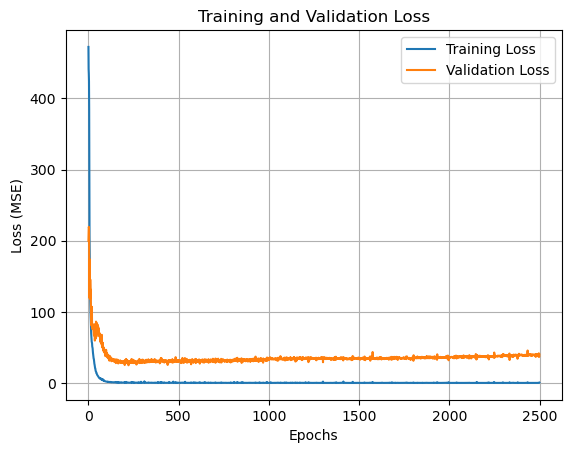

In [24]:
model_naive_B2_4 = lm_naive_B2.main()
history = model_naive_B2_4.fit(C_train_4, P_train_4, epochs=2500, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()
finalLoss_naive_B2_4 = history.history['loss'][-1] 
finalValLoss_naive_B2_4 = history.history['val_loss'][-1]


Epoch 1/2500
50/50 [==============================] - 0s 2ms/step - loss: 39.5656 - val_loss: 36.5775
Epoch 2/2500
50/50 [==============================] - 0s 2ms/step - loss: 11.5488 - val_loss: 37.5742
Epoch 3/2500
50/50 [==============================] - 0s 2ms/step - loss: 6.1790 - val_loss: 26.7563
Epoch 4/2500
50/50 [==============================] - 0s 2ms/step - loss: 3.5676 - val_loss: 20.7533
Epoch 5/2500
50/50 [==============================] - 0s 2ms/step - loss: 2.5696 - val_loss: 19.0265
Epoch 6/2500
50/50 [==============================] - 0s 2ms/step - loss: 1.8088 - val_loss: 18.3002
Epoch 7/2500
50/50 [==============================] - 0s 2ms/step - loss: 1.5887 - val_loss: 19.6168
Epoch 8/2500
50/50 [==============================] - 0s 2ms/step - loss: 1.4858 - val_loss: 15.9393
Epoch 9/2500
50/50 [==============================] - 0s 2ms/step - loss: 1.1196 - val_loss: 17.5101
Epoch 10/2500
50/50 [==============================] - 0s 2ms/step - loss: 0.9920 - val_l

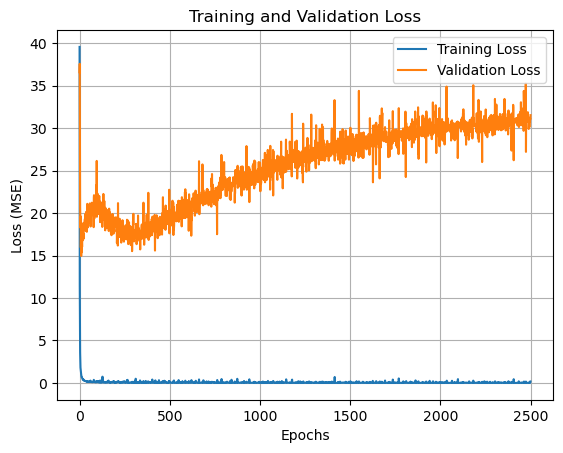

In [25]:
model_naive_B2_5 = lm_naive_B2.main()
history = model_naive_B2_5.fit(C_train_5, P_train_5, epochs=2500, validation_data=(C_test, P_test))
# 训练过程的可视化
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()
finalLoss_naive_B2_5 = history.history['loss'][-1]
finalValLoss_naive_B2_5 = history.history['val_loss'][-1]

Epoch 1/2500
100/100 [==============================] - 0s 2ms/step - loss: 20.3539 - val_loss: 14.5111
Epoch 2/2500
100/100 [==============================] - 0s 2ms/step - loss: 4.3629 - val_loss: 7.7650
Epoch 3/2500
100/100 [==============================] - 0s 2ms/step - loss: 2.3379 - val_loss: 7.5168
Epoch 4/2500
100/100 [==============================] - 0s 2ms/step - loss: 1.5666 - val_loss: 6.3373
Epoch 5/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.1198 - val_loss: 6.1765
Epoch 6/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.8412 - val_loss: 5.5627
Epoch 7/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.6934 - val_loss: 5.1091
Epoch 8/2500
100/100 [==============================] - 0s 2ms/step - loss: 0.5718 - val_loss: 4.8248
Epoch 9/2500
100/100 [==============================] - 0s 2ms/step - loss: 0.4982 - val_loss: 4.9553
Epoch 10/2500
100/100 [==============================] - 0s 2ms/step - loss: 0.4

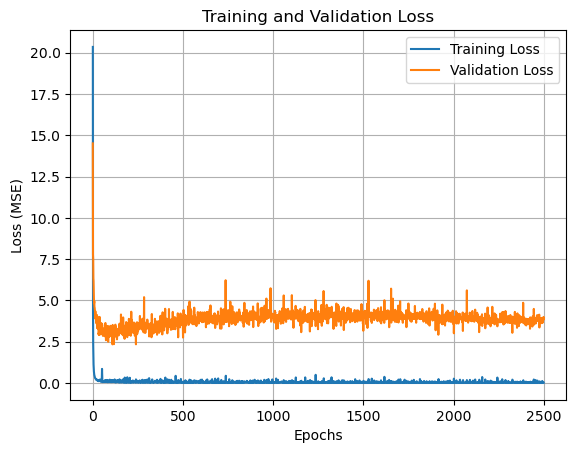

In [26]:
model_naive_B2_6 = lm_naive_B2.main()
history = model_naive_B2_6.fit(C_train_6, P_train_6, epochs=2500, validation_data=(C_test, P_test))
# 训练过程的可视化
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()
finalLoss_naive_B2_6 = history.history['loss'][-1]
finalValLoss_naive_B2_6 = history.history['val_loss'][-1]

Epoch 1/2500
150/150 [==============================] - 1s 2ms/step - loss: 356.1247 - val_loss: 322.7171
Epoch 2/2500
150/150 [==============================] - 0s 1ms/step - loss: 143.8619 - val_loss: 55.0581
Epoch 3/2500
150/150 [==============================] - 0s 1ms/step - loss: 95.4390 - val_loss: 31.0793
Epoch 4/2500
150/150 [==============================] - 0s 2ms/step - loss: 89.4116 - val_loss: 26.4173
Epoch 5/2500
150/150 [==============================] - 0s 1ms/step - loss: 84.8565 - val_loss: 35.9004
Epoch 6/2500
150/150 [==============================] - 0s 1ms/step - loss: 79.1228 - val_loss: 12.7798
Epoch 7/2500
150/150 [==============================] - 0s 1ms/step - loss: 71.6060 - val_loss: 20.9335
Epoch 8/2500
150/150 [==============================] - 0s 1ms/step - loss: 64.4220 - val_loss: 36.2905
Epoch 9/2500
150/150 [==============================] - 0s 1ms/step - loss: 57.9779 - val_loss: 26.6936
Epoch 10/2500
150/150 [==============================] - 0s 1

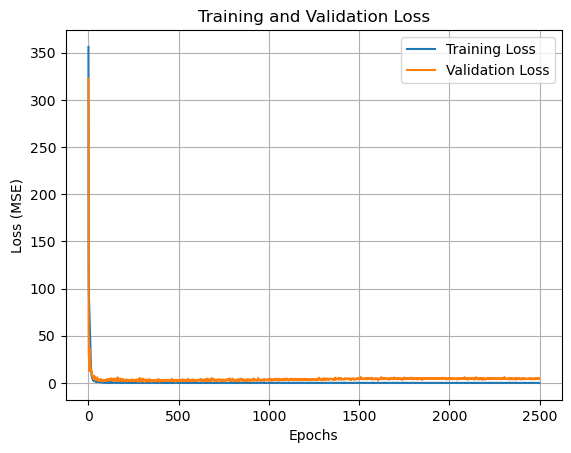

In [79]:
model_naive_B2_658 = lm_naive_B2.main()
history = model_naive_B2_658.fit(C_train_658, P_train_658, epochs=2500, validation_data=(C_test, P_test))
# 训练过程的可视化
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()
finalLoss_naive_B2_658 = history.history['loss'][-1]
finalValLoss_naive_B2_658 = history.history['val_loss'][-1]

### ICNN model A1

In [30]:

import models_icnn_A1 as lm2_icnn_A1

import importlib
importlib.reload(lm2_icnn_A1)
model_icnn_A1 = lm2_icnn_A1.main()

model_icnn_A1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5)]               0         
                                                                 
 private_c_to_w_4 (_C_to_W)  (None, 1)                 57        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [31]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)


def train_step(F, P_true, model):
    with tf.GradientTape(persistent=True) as tape:  
        tape.watch(F)
        
        
        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)
        
        
        P_pred = tape.gradient(W_pred, F)
        
        
        loss_P = tf.reduce_mean(tf.square(P_pred - P_true))  
        loss = loss_P
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss


In [14]:
I1_data_train_4, J_data_train_4, I4_data_train_4, I5_data_train_4 = compute_invariants(F_train_4)
I1_data_train_5, J_data_train_5, I4_data_train_5, I5_data_train_5 = compute_invariants(F_train_5)
I1_data_train_6, J_data_train_6, I4_data_train_6, I5_data_train_6 = compute_invariants(F_train_6)
I1_data_train_658, J_data_train_658, I4_data_train_658, I5_data_train_658 = compute_invariants(F_train_658)
I1_data_test, J_data_test, I4_data_test, I5_data_test = compute_invariants(F_test)


In [15]:
I_train_4 = np.column_stack((I1_data_train_4, J_data_train_4, -J_data_train_4, I4_data_train_4, I5_data_train_4))
I_train_5 = np.column_stack((I1_data_train_5, J_data_train_5, -J_data_train_5, I4_data_train_5, I5_data_train_5))
I_train_6 = np.column_stack((I1_data_train_6, J_data_train_6, -J_data_train_6, I4_data_train_6, I5_data_train_6))
I_train_658 = np.column_stack((I1_data_train_658, J_data_train_658, -J_data_train_658, I4_data_train_658, I5_data_train_658))
I_test = np.column_stack((I1_data_test, J_data_test, -J_data_test, I4_data_test, I5_data_test))



In [16]:
I_train_tensor_4 = tf.convert_to_tensor(I_train_4, dtype=tf.float32)
I_train_tensor_5 = tf.convert_to_tensor(I_train_5, dtype=tf.float32)
I_train_tensor_6 = tf.convert_to_tensor(I_train_6, dtype=tf.float32)
I_train_tensor_658 = tf.convert_to_tensor(I_train_658, dtype=tf.float32)
I_test_tensor = tf.convert_to_tensor(I_test, dtype=tf.float32)

In [17]:
W_train_tensor_4 = neo_hookean_potential(I1_data_train_4, J_data_train_4, I4_data_train_4, I5_data_train_4)
W_train_tensor_5 = neo_hookean_potential(I1_data_train_5, J_data_train_5, I4_data_train_5, I5_data_train_5)
W_train_tensor_6 = neo_hookean_potential(I1_data_train_6, J_data_train_6, I4_data_train_6, I5_data_train_6)
W_train_tensor_658 = neo_hookean_potential(I1_data_train_658, J_data_train_658, I4_data_train_658, I5_data_train_658)
w_test_tensor = neo_hookean_potential(I1_data_test, J_data_test, I4_data_test, I5_data_test)


In [27]:
F_train_tensor_4 = tf.convert_to_tensor(F_train_4, dtype=tf.float32)
F_train_tensor_5 = tf.convert_to_tensor(F_train_5, dtype=tf.float32)
F_train_tensor_6 = tf.convert_to_tensor(F_train_6, dtype=tf.float32)
F_train_tensor_658 = tf.convert_to_tensor(F_train_658, dtype=tf.float32)
F_test_tensor = tf.convert_to_tensor(F_test, dtype=tf.float32)

In [32]:
import matplotlib.pyplot as plt
model_icnn_A1_4 = lm2_icnn_A1.main()
history = model_icnn_A1_4.fit(I_train_tensor_4, W_train_tensor_4, epochs=2500)



Epoch 1/2500
25/25 [==============================] - 0s 987us/step - loss: 294.5102
Epoch 2/2500
25/25 [==============================] - 0s 933us/step - loss: 270.4048
Epoch 3/2500
25/25 [==============================] - 0s 994us/step - loss: 244.1880
Epoch 4/2500
25/25 [==============================] - 0s 1ms/step - loss: 218.9691
Epoch 5/2500
25/25 [==============================] - 0s 928us/step - loss: 194.7302
Epoch 6/2500
25/25 [==============================] - 0s 996us/step - loss: 175.8223
Epoch 7/2500
25/25 [==============================] - 0s 1ms/step - loss: 163.3334
Epoch 8/2500
25/25 [==============================] - 0s 910us/step - loss: 156.7552
Epoch 9/2500
25/25 [==============================] - 0s 947us/step - loss: 154.3415
Epoch 10/2500
25/25 [==============================] - 0s 1ms/step - loss: 152.5821
Epoch 11/2500
25/25 [==============================] - 0s 1ms/step - loss: 151.4872
Epoch 12/2500
25/25 [==============================] - 0s 1ms/step - lo

In [33]:

for epoch in range(2500):
   
    loss = train_step(F_train_tensor_4, P_train_tensor_4, model_icnn_A1_4)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    finalLoss_icnn_A1_4 = loss.numpy()

Epoch 1, Loss: 30.95351219177246
Epoch 2, Loss: 30.469839096069336
Epoch 3, Loss: 30.00472640991211
Epoch 4, Loss: 29.55807876586914
Epoch 5, Loss: 29.128389358520508
Epoch 6, Loss: 28.714303970336914
Epoch 7, Loss: 28.31550407409668
Epoch 8, Loss: 27.932178497314453
Epoch 9, Loss: 27.564598083496094
Epoch 10, Loss: 27.21297264099121
Epoch 11, Loss: 26.877422332763672
Epoch 12, Loss: 26.557979583740234
Epoch 13, Loss: 26.254581451416016
Epoch 14, Loss: 25.96706199645996
Epoch 15, Loss: 25.695152282714844
Epoch 16, Loss: 25.438514709472656
Epoch 17, Loss: 25.196714401245117
Epoch 18, Loss: 24.969263076782227
Epoch 19, Loss: 24.755598068237305
Epoch 20, Loss: 24.555126190185547
Epoch 21, Loss: 24.36721420288086
Epoch 22, Loss: 24.191184997558594
Epoch 23, Loss: 24.026363372802734
Epoch 24, Loss: 23.87208366394043
Epoch 25, Loss: 23.7276554107666
Epoch 26, Loss: 23.592409133911133
Epoch 27, Loss: 23.465694427490234
Epoch 28, Loss: 23.346885681152344
Epoch 29, Loss: 23.235361099243164
Epoc

In [34]:
model_icnn_A1_5 = lm2_icnn_A1.main()
history = model_icnn_A1_5.fit(I_train_tensor_5, W_train_tensor_5, epochs=2500,verbose=0)
for epoch in range(2500):
   
    loss = train_step(F_train_tensor_5, P_train_tensor_5, model_icnn_A1_5)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    finalLoss_icnn_A1_5 = loss.numpy()
    


Epoch 1, Loss: 24.920137405395508
Epoch 2, Loss: 23.42872428894043
Epoch 3, Loss: 21.63566780090332
Epoch 4, Loss: 19.852380752563477
Epoch 5, Loss: 18.270919799804688
Epoch 6, Loss: 17.001373291015625
Epoch 7, Loss: 16.078981399536133
Epoch 8, Loss: 15.480327606201172
Epoch 9, Loss: 15.144746780395508
Epoch 10, Loss: 14.9967622756958
Epoch 11, Loss: 14.963622093200684
Epoch 12, Loss: 14.98453140258789
Epoch 13, Loss: 15.013205528259277
Epoch 14, Loss: 15.018463134765625
Epoch 15, Loss: 14.984713554382324
Epoch 16, Loss: 14.909043312072754
Epoch 17, Loss: 14.795492172241211
Epoch 18, Loss: 14.650727272033691
Epoch 19, Loss: 14.482855796813965
Epoch 20, Loss: 14.30120849609375
Epoch 21, Loss: 14.114787101745605
Epoch 22, Loss: 13.930464744567871
Epoch 23, Loss: 13.752494812011719
Epoch 24, Loss: 13.58326530456543
Epoch 25, Loss: 13.424031257629395
Epoch 26, Loss: 13.275222778320312
Epoch 27, Loss: 13.136725425720215
Epoch 28, Loss: 13.00815200805664
Epoch 29, Loss: 12.888961791992188
Ep

In [35]:
model_icnn_A1_6 = lm2_icnn_A1.main()
history = model_icnn_A1_6.fit(I_train_tensor_6, W_train_tensor_6, epochs=2500,verbose=0)
for epoch in range(2500):
   
    loss = train_step(F_train_tensor_6, P_train_tensor_6, model_icnn_A1_6)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    finalLoss_icnn_A1_6 = loss.numpy()

Epoch 1, Loss: 31.746761322021484
Epoch 2, Loss: 29.92947006225586
Epoch 3, Loss: 27.739408493041992
Epoch 4, Loss: 25.585407257080078
Epoch 5, Loss: 23.723146438598633
Epoch 6, Loss: 22.29044532775879
Epoch 7, Loss: 21.320249557495117
Epoch 8, Loss: 20.765079498291016
Epoch 9, Loss: 20.530519485473633
Epoch 10, Loss: 20.50713539123535
Epoch 11, Loss: 20.59263801574707
Epoch 12, Loss: 20.703845977783203
Epoch 13, Loss: 20.781156539916992
Epoch 14, Loss: 20.788070678710938
Epoch 15, Loss: 20.708263397216797
Epoch 16, Loss: 20.541311264038086
Epoch 17, Loss: 20.298025131225586
Epoch 18, Loss: 19.9960994720459
Epoch 19, Loss: 19.6564884185791
Epoch 20, Loss: 19.30055809020996
Epoch 21, Loss: 18.948001861572266
Epoch 22, Loss: 18.6153564453125
Epoch 23, Loss: 18.315048217773438
Epoch 24, Loss: 18.054889678955078
Epoch 25, Loss: 17.837963104248047
Epoch 26, Loss: 17.66293716430664
Epoch 27, Loss: 17.524770736694336
Epoch 28, Loss: 17.415721893310547
Epoch 29, Loss: 17.32660675048828
Epoch 3

In [41]:
model_icnn_A1_658 = lm2_icnn_A1.main()
history = model_icnn_A1_658.fit(I_train_tensor_658, W_train_tensor_658, epochs=2500,verbose=0)
for epoch in range(2500):
   
    loss = train_step(F_train_tensor_658, P_train_tensor_658, model_icnn_A1_658)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    finalLoss_icnn_A1_658 = loss.numpy()


Epoch 1, Loss: 34.009586334228516
Epoch 2, Loss: 31.489450454711914
Epoch 3, Loss: 28.46851348876953
Epoch 4, Loss: 25.533510208129883
Epoch 5, Loss: 23.019468307495117
Epoch 6, Loss: 21.083194732666016
Epoch 7, Loss: 19.751989364624023
Epoch 8, Loss: 18.966421127319336
Epoch 9, Loss: 18.607025146484375
Epoch 10, Loss: 18.521484375
Epoch 11, Loss: 18.581295013427734
Epoch 12, Loss: 18.700593948364258
Epoch 13, Loss: 18.820697784423828
Epoch 14, Loss: 18.902694702148438
Epoch 15, Loss: 18.927000045776367
Epoch 16, Loss: 18.89218521118164
Epoch 17, Loss: 18.809118270874023
Epoch 18, Loss: 18.69188117980957
Epoch 19, Loss: 18.551563262939453
Epoch 20, Loss: 18.395977020263672
Epoch 21, Loss: 18.231510162353516
Epoch 22, Loss: 18.063743591308594
Epoch 23, Loss: 17.896596908569336
Epoch 24, Loss: 17.73155975341797
Epoch 25, Loss: 17.568416595458984
Epoch 26, Loss: 17.407268524169922
Epoch 27, Loss: 17.24980926513672
Epoch 28, Loss: 17.098770141601562
Epoch 29, Loss: 16.956417083740234
Epoch

### ICNN model A2

In [36]:
import models_icnn_A2 as lm2_icnn_A2

import importlib
importlib.reload(lm2_icnn_A2)
model_icnn_A2 = lm2_icnn_A2.main()

model_icnn_A2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 5)]               0         
                                                                 
 private_c_to_w_8 (_C_to_W)  (None, 1)                 385       
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_icnn_A2_4 = lm2_icnn_A2.main()
history = model_icnn_A2_4.fit(I_train_tensor_4, W_train_tensor_4, epochs=2500,verbose=0)
for epoch in range(2500):
   
    loss = train_step(F_train_tensor_4, P_train_tensor_4, model_icnn_A2_4)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    finalLoss_icnn_A2_4 = loss.numpy()


Epoch 1, Loss: 39.16965866088867
Epoch 2, Loss: 36.41292953491211
Epoch 3, Loss: 33.37483215332031
Epoch 4, Loss: 30.547414779663086
Epoch 5, Loss: 27.999847412109375
Epoch 6, Loss: 25.603940963745117
Epoch 7, Loss: 23.309001922607422
Epoch 8, Loss: 21.24620246887207
Epoch 9, Loss: 19.5991268157959
Epoch 10, Loss: 18.41287612915039
Epoch 11, Loss: 17.523204803466797
Epoch 12, Loss: 16.73529052734375
Epoch 13, Loss: 15.998372077941895
Epoch 14, Loss: 15.372276306152344
Epoch 15, Loss: 14.907122611999512
Epoch 16, Loss: 14.574211120605469
Epoch 17, Loss: 14.28773307800293
Epoch 18, Loss: 13.982348442077637
Epoch 19, Loss: 13.663580894470215
Epoch 20, Loss: 13.385770797729492
Epoch 21, Loss: 13.190682411193848
Epoch 22, Loss: 13.067564010620117
Epoch 23, Loss: 12.9705228805542
Epoch 24, Loss: 12.867981910705566
Epoch 25, Loss: 12.767048835754395
Epoch 26, Loss: 12.69202709197998
Epoch 27, Loss: 12.648810386657715
Epoch 28, Loss: 12.614945411682129
Epoch 29, Loss: 12.561923027038574
Epoch 

In [38]:
model_icnn_A2_5 = lm2_icnn_A2.main()
history = model_icnn_A2_5.fit(I_train_tensor_5, W_train_tensor_5, epochs=2500,verbose=0)
for epoch in range(2500):
   
    loss = train_step(F_train_tensor_5, P_train_tensor_5, model_icnn_A2_5)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    finalLoss_icnn_A2_5 = loss.numpy()

Epoch 1, Loss: 53.94701385498047
Epoch 2, Loss: 48.983001708984375
Epoch 3, Loss: 43.717891693115234
Epoch 4, Loss: 39.08116912841797
Epoch 5, Loss: 35.2430419921875
Epoch 6, Loss: 31.95288848876953
Epoch 7, Loss: 28.93080711364746
Epoch 8, Loss: 26.126211166381836
Epoch 9, Loss: 23.72646141052246
Epoch 10, Loss: 21.982952117919922
Epoch 11, Loss: 20.927898406982422
Epoch 12, Loss: 20.24924659729004
Epoch 13, Loss: 19.589014053344727
Epoch 14, Loss: 18.83614158630371
Epoch 15, Loss: 18.078838348388672
Epoch 16, Loss: 17.42086410522461
Epoch 17, Loss: 16.876161575317383
Epoch 18, Loss: 16.375499725341797
Epoch 19, Loss: 15.832601547241211
Epoch 20, Loss: 15.204030990600586
Epoch 21, Loss: 14.507513046264648
Epoch 22, Loss: 13.801985740661621
Epoch 23, Loss: 13.151241302490234
Epoch 24, Loss: 12.593132972717285
Epoch 25, Loss: 12.12848949432373
Epoch 26, Loss: 11.733413696289062
Epoch 27, Loss: 11.390664100646973
Epoch 28, Loss: 11.07666015625
Epoch 29, Loss: 10.796708106994629
Epoch 30,

In [39]:
model_icnn_A2_6 = lm2_icnn_A2.main()
history = model_icnn_A2_6.fit(I_train_tensor_6, W_train_tensor_6, epochs=2500,verbose=0)
for epoch in range(2500):
   
    loss = train_step(F_train_tensor_6, P_train_tensor_6, model_icnn_A2_6)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    finalLoss_icnn_A2_6 = loss.numpy()


Epoch 1, Loss: 49.67439270019531
Epoch 2, Loss: 46.02678680419922
Epoch 3, Loss: 42.319244384765625
Epoch 4, Loss: 38.90559768676758
Epoch 5, Loss: 35.6534423828125
Epoch 6, Loss: 32.5057258605957
Epoch 7, Loss: 29.509756088256836
Epoch 8, Loss: 26.792648315429688
Epoch 9, Loss: 24.50694465637207
Epoch 10, Loss: 22.708646774291992
Epoch 11, Loss: 21.282590866088867
Epoch 12, Loss: 20.035255432128906
Epoch 13, Loss: 18.853168487548828
Epoch 14, Loss: 17.74892807006836
Epoch 15, Loss: 16.79029655456543
Epoch 16, Loss: 16.006271362304688
Epoch 17, Loss: 15.375381469726562
Epoch 18, Loss: 14.825398445129395
Epoch 19, Loss: 14.323203086853027
Epoch 20, Loss: 13.857002258300781
Epoch 21, Loss: 13.446897506713867
Epoch 22, Loss: 13.114957809448242
Epoch 23, Loss: 12.86324405670166
Epoch 24, Loss: 12.668582916259766
Epoch 25, Loss: 12.504976272583008
Epoch 26, Loss: 12.361482620239258
Epoch 27, Loss: 12.227132797241211
Epoch 28, Loss: 12.112653732299805
Epoch 29, Loss: 12.026383399963379
Epoch

In [40]:
model_icnn_A2_658 = lm2_icnn_A2.main()
history = model_icnn_A2_658.fit(I_train_tensor_658, W_train_tensor_658, epochs=2500,verbose=0)
for epoch in range(2500):
   
    loss = train_step(F_train_tensor_658, P_train_tensor_658, model_icnn_A2_658)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    finalLoss_icnn_A2_658 = loss.numpy()


Epoch 1, Loss: 51.769630432128906
Epoch 2, Loss: 48.05030822753906
Epoch 3, Loss: 43.97709655761719
Epoch 4, Loss: 39.97831726074219
Epoch 5, Loss: 36.25844192504883
Epoch 6, Loss: 32.88254165649414
Epoch 7, Loss: 29.85874366760254
Epoch 8, Loss: 27.195966720581055
Epoch 9, Loss: 24.91938018798828
Epoch 10, Loss: 23.024776458740234
Epoch 11, Loss: 21.453792572021484
Epoch 12, Loss: 20.120695114135742
Epoch 13, Loss: 18.959016799926758
Epoch 14, Loss: 17.930103302001953
Epoch 15, Loss: 17.01471710205078
Epoch 16, Loss: 16.215227127075195
Epoch 17, Loss: 15.547065734863281
Epoch 18, Loss: 14.973892211914062
Epoch 19, Loss: 14.47877311706543
Epoch 20, Loss: 14.047277450561523
Epoch 21, Loss: 13.666304588317871
Epoch 22, Loss: 13.328597068786621
Epoch 23, Loss: 13.039660453796387
Epoch 24, Loss: 12.801687240600586
Epoch 25, Loss: 12.610387802124023
Epoch 26, Loss: 12.455923080444336
Epoch 27, Loss: 12.323868751525879
Epoch 28, Loss: 12.207655906677246
Epoch 29, Loss: 12.106395721435547
Epo

### comparisons

In [42]:
finalLoss_naive_B1_4 = 95.3168
finalLoss_naive_B1_5 = 62.9713
finalLoss_naive_B1_6 = 17.5767
finalLoss_naive_B1_658 = 4.2831
finalLoss_naive_B2_4 = 39.9562
finalLoss_naive_B2_5 = 31.5317
finalLoss_naive_B2_6 = 3.8364
finalLoss_naive_B2_658 = 2.9251

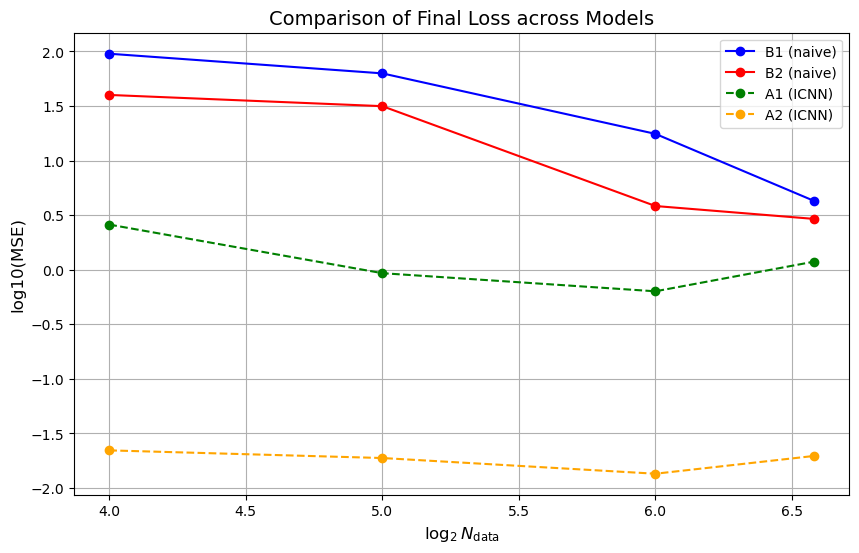

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# 模拟数据
log2Ndata = [4, 5, 6, 6.58]  # log2Ndata的值

# 替换为实际的final loss数据
finalLoss_naive_B1 = [finalLoss_naive_B1_4, finalLoss_naive_B1_5, finalLoss_naive_B1_6, finalLoss_naive_B1_658]
finalLoss_naive_B2 = [finalLoss_naive_B2_4, finalLoss_naive_B2_5, finalLoss_naive_B2_6, finalLoss_naive_B2_658]
finalLoss_icnn_A1 = [finalLoss_icnn_A1_4, finalLoss_icnn_A1_5, finalLoss_icnn_A1_6, finalLoss_icnn_A1_658]
finalLoss_icnn_A2 = [finalLoss_icnn_A2_4, finalLoss_icnn_A2_5, finalLoss_icnn_A2_6, finalLoss_icnn_A2_658]

# 画图
plt.figure(figsize=(10, 6))

# 绘制不同模型的曲线
plt.plot(log2Ndata, np.log10(finalLoss_naive_B1), label="B1 (naive)", marker='o', linestyle='-', color='blue')
plt.plot(log2Ndata, np.log10(finalLoss_naive_B2), label="B2 (naive)", marker='o', linestyle='-', color='red')
plt.plot(log2Ndata, np.log10(finalLoss_icnn_A1), label="A1 (ICNN)", marker='o', linestyle='--', color='green')
plt.plot(log2Ndata, np.log10(finalLoss_icnn_A2), label="A2 (ICNN)", marker='o', linestyle='--', color='orange')

# 设置图例和轴标签
plt.xlabel(r"$\log_2 N_{\text{data}}$", fontsize=12)
plt.ylabel("log10(MSE)", fontsize=12)
plt.title("Comparison of Final Loss across Models", fontsize=14)
plt.legend()
plt.grid(True)

# 显示图形
plt.show()


In [47]:
def compute_stress_tensor_model(F,model):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(F)
        

        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)

  
    P = tape.gradient(W_pred, F)
    
 
    #print("P:", P)
    
    return P

In [48]:
P_test_pred_A1_4 = compute_stress_tensor_model(F_test,model_icnn_A1_4)
P_test_pred_A1_5 = compute_stress_tensor_model(F_test,model_icnn_A1_5)
P_test_pred_A1_6 = compute_stress_tensor_model(F_test,model_icnn_A1_6)
P_test_pred_A1_658 = compute_stress_tensor_model(F_test,model_icnn_A1_658)
P_test_pred_A2_4 = compute_stress_tensor_model(F_test,model_icnn_A2_4)
P_test_pred_A2_5 = compute_stress_tensor_model(F_test,model_icnn_A2_5)
P_test_pred_A2_6 = compute_stress_tensor_model(F_test,model_icnn_A2_6)
P_test_pred_A2_658 = compute_stress_tensor_model(F_test,model_icnn_A2_658)





In [56]:
def calculate_mse(P_test_pred, P_test):

    P_test = tf.convert_to_tensor(P_test.reshape(-1,3,3), dtype=tf.float32)

    mse = tf.reduce_mean(tf.square(P_test_pred - P_test))

    return mse.numpy()  

In [57]:
finalValLoss_icnn_A1_4 = calculate_mse(P_test_pred_A1_4, P_test)
finalValLoss_icnn_A1_5 = calculate_mse(P_test_pred_A1_5, P_test)
finalValLoss_icnn_A1_6 = calculate_mse(P_test_pred_A1_6, P_test)
finalValLoss_icnn_A1_658 = calculate_mse(P_test_pred_A1_658, P_test)
finalValLoss_icnn_A2_4 = calculate_mse(P_test_pred_A2_4, P_test)
finalValLoss_icnn_A2_5 = calculate_mse(P_test_pred_A2_5, P_test)
finalValLoss_icnn_A2_6 = calculate_mse(P_test_pred_A2_6, P_test)
finalValLoss_icnn_A2_658 = calculate_mse(P_test_pred_A2_658, P_test)


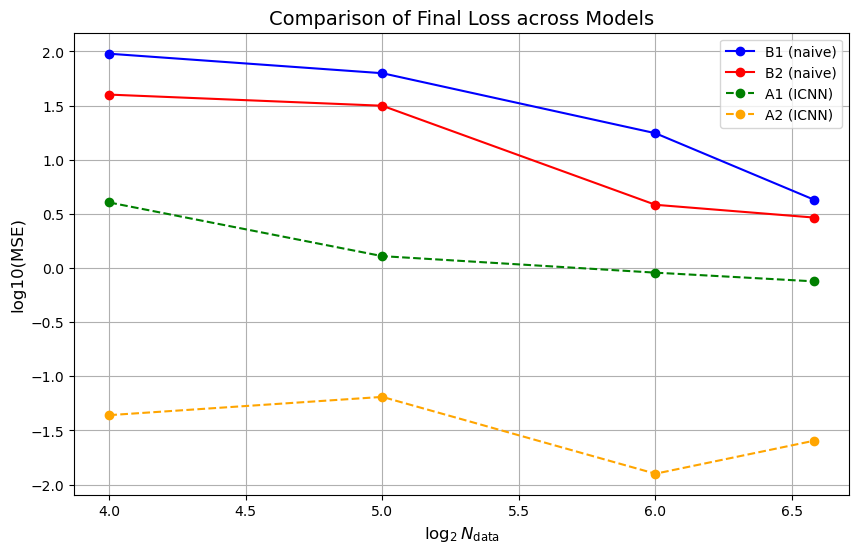

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 模拟数据
log2Ndata = [4, 5, 6, 6.58]  # log2Ndata的值

# 替换为实际的final loss数据
finalValLoss_naive_B1 = [finalValLoss_naive_B1_4, finalValLoss_naive_B1_5, finalValLoss_naive_B1_6, finalValLoss_naive_B1_658]
finalValLoss_naive_B2 = [finalValLoss_naive_B2_4, finalValLoss_naive_B2_5, finalValLoss_naive_B2_6, finalValLoss_naive_B2_658]
finalValLoss_icnn_A1 = [finalValLoss_icnn_A1_4, finalValLoss_icnn_A1_5, finalValLoss_icnn_A1_6, finalValLoss_icnn_A1_658]
finalValLoss_icnn_A2 = [finalValLoss_icnn_A2_4, finalValLoss_icnn_A2_5, finalValLoss_icnn_A2_6, finalValLoss_icnn_A2_658]

# 画图
plt.figure(figsize=(10, 6))

# 绘制不同模型的曲线
plt.plot(log2Ndata, np.log10(finalValLoss_naive_B1), label="B1 (naive)", marker='o', linestyle='-', color='blue')
plt.plot(log2Ndata, np.log10(finalValLoss_naive_B2), label="B2 (naive)", marker='o', linestyle='-', color='red')
plt.plot(log2Ndata, np.log10(finalValLoss_icnn_A1), label="A1 (ICNN)", marker='o', linestyle='--', color='green')
plt.plot(log2Ndata, np.log10(finalValLoss_icnn_A2), label="A2 (ICNN)", marker='o', linestyle='--', color='orange')

# 设置图例和轴标签
plt.xlabel(r"$\log_2 N_{\text{data}}$", fontsize=12)
plt.ylabel("log10(MSE)", fontsize=12)
plt.title("Comparison of Final Loss across Models", fontsize=14)
plt.legend()
plt.grid(True)

# 显示图形
plt.show()


C:\Users\10472\AppData\Local\Temp\ipykernel_17784\3208653706.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axs[index].plot(F11_test[indices], P_test[indices, i, j], 'b-', marker='^',


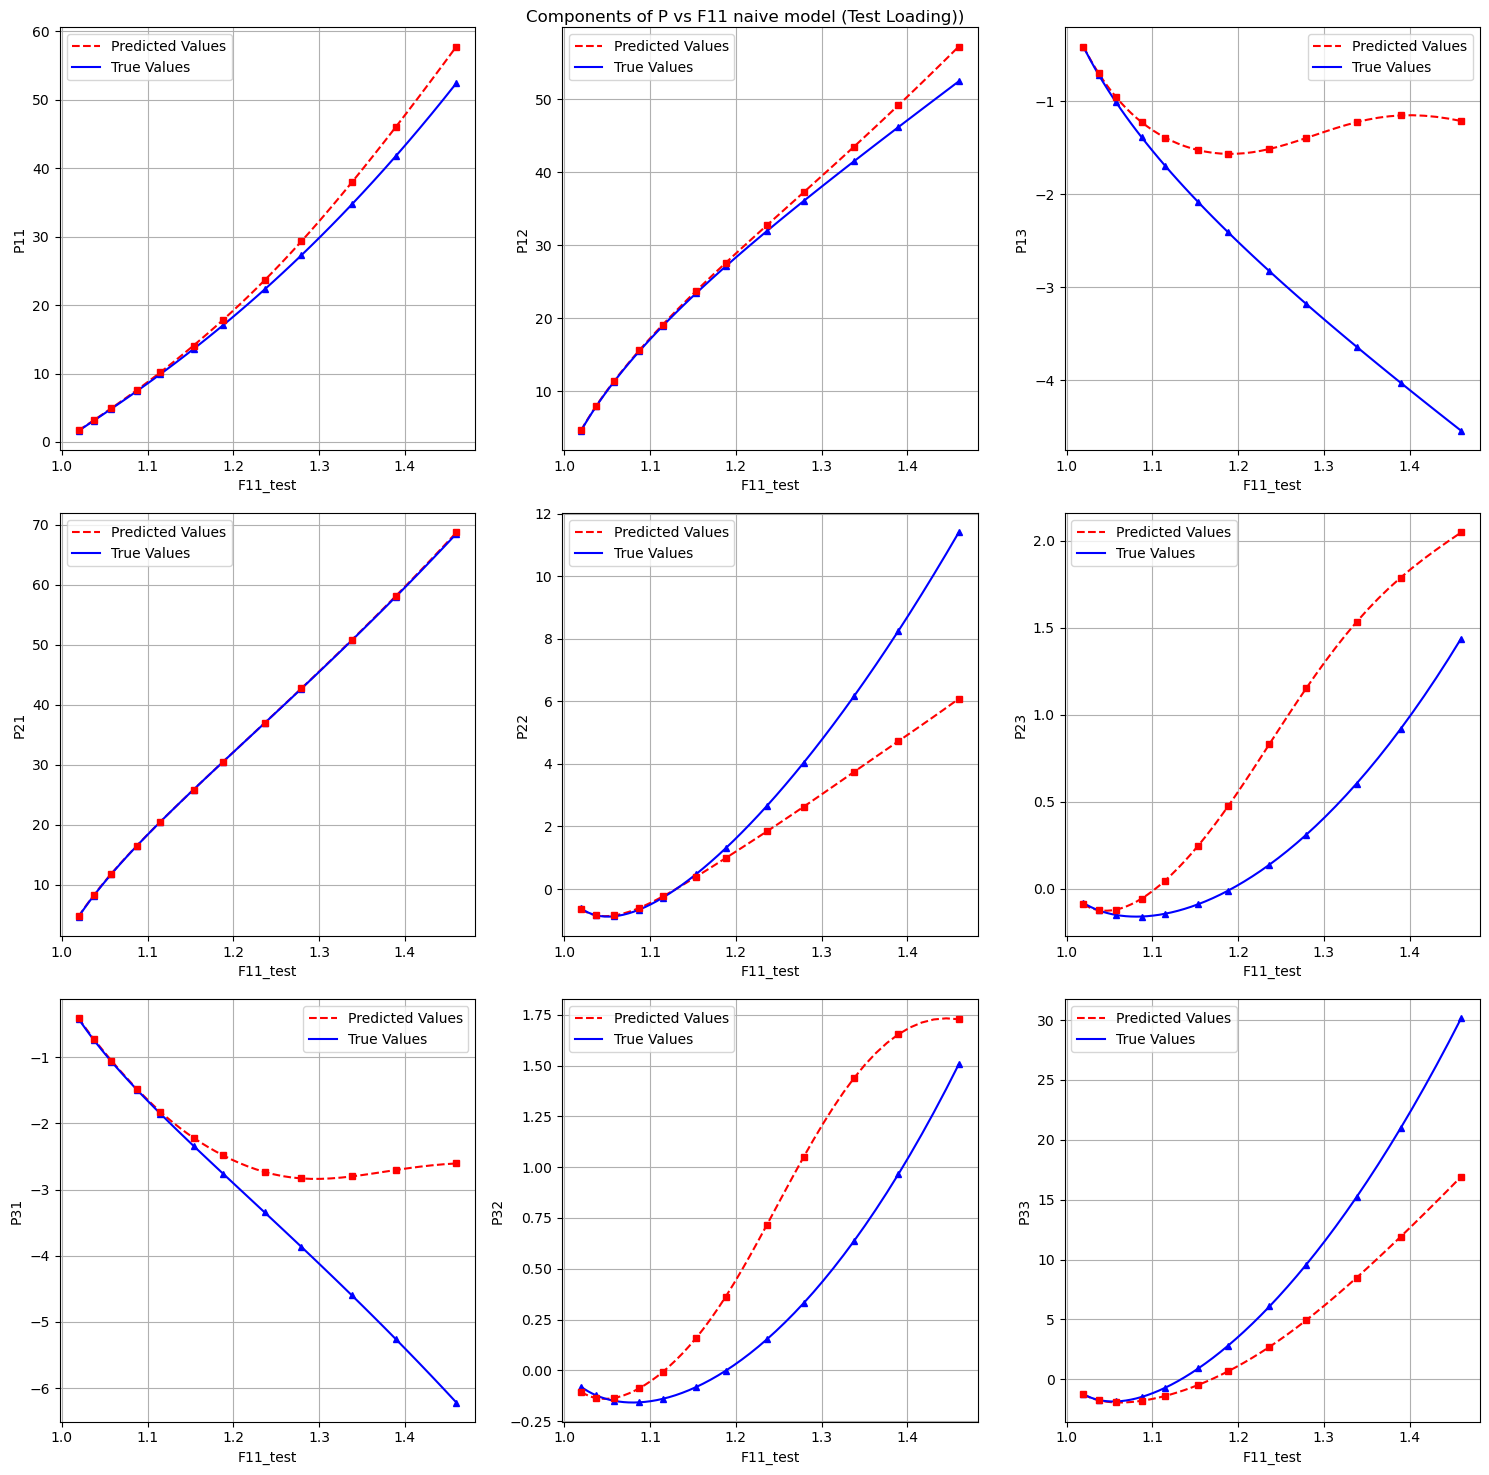

In [80]:
import matplotlib.pyplot as plt
import numpy as np

P_test_pred = model_naive_B2_658(C_test).numpy().reshape(-1, 3, 3)
F11_test = F_test[:, 0, 0]

# Select 12 evenly spaced indices
total_points = len(F11_test)
indices = np.linspace(0, total_points-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 naive model (Test Loading))')

# Flatten the axs array for easier iteration
axs = axs.flatten()
P_test = P_test.reshape(-1, 3, 3)
# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_test, P_test_pred[:, i, j], 'r--', label='Predicted Values')
        # Plot the continuous true values with solid blue line
        axs[index].plot(F11_test, P_test[:, i, j], 'b-', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_test[indices], P_test[indices, i, j], 'b-', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_test[indices], P_test_pred[indices, i, j], 'r', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()


C:\Users\10472\AppData\Local\Temp\ipykernel_17784\689055026.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axs[index].plot(F11_test[indices], P_test[indices, i, j], 'b-', marker='^',


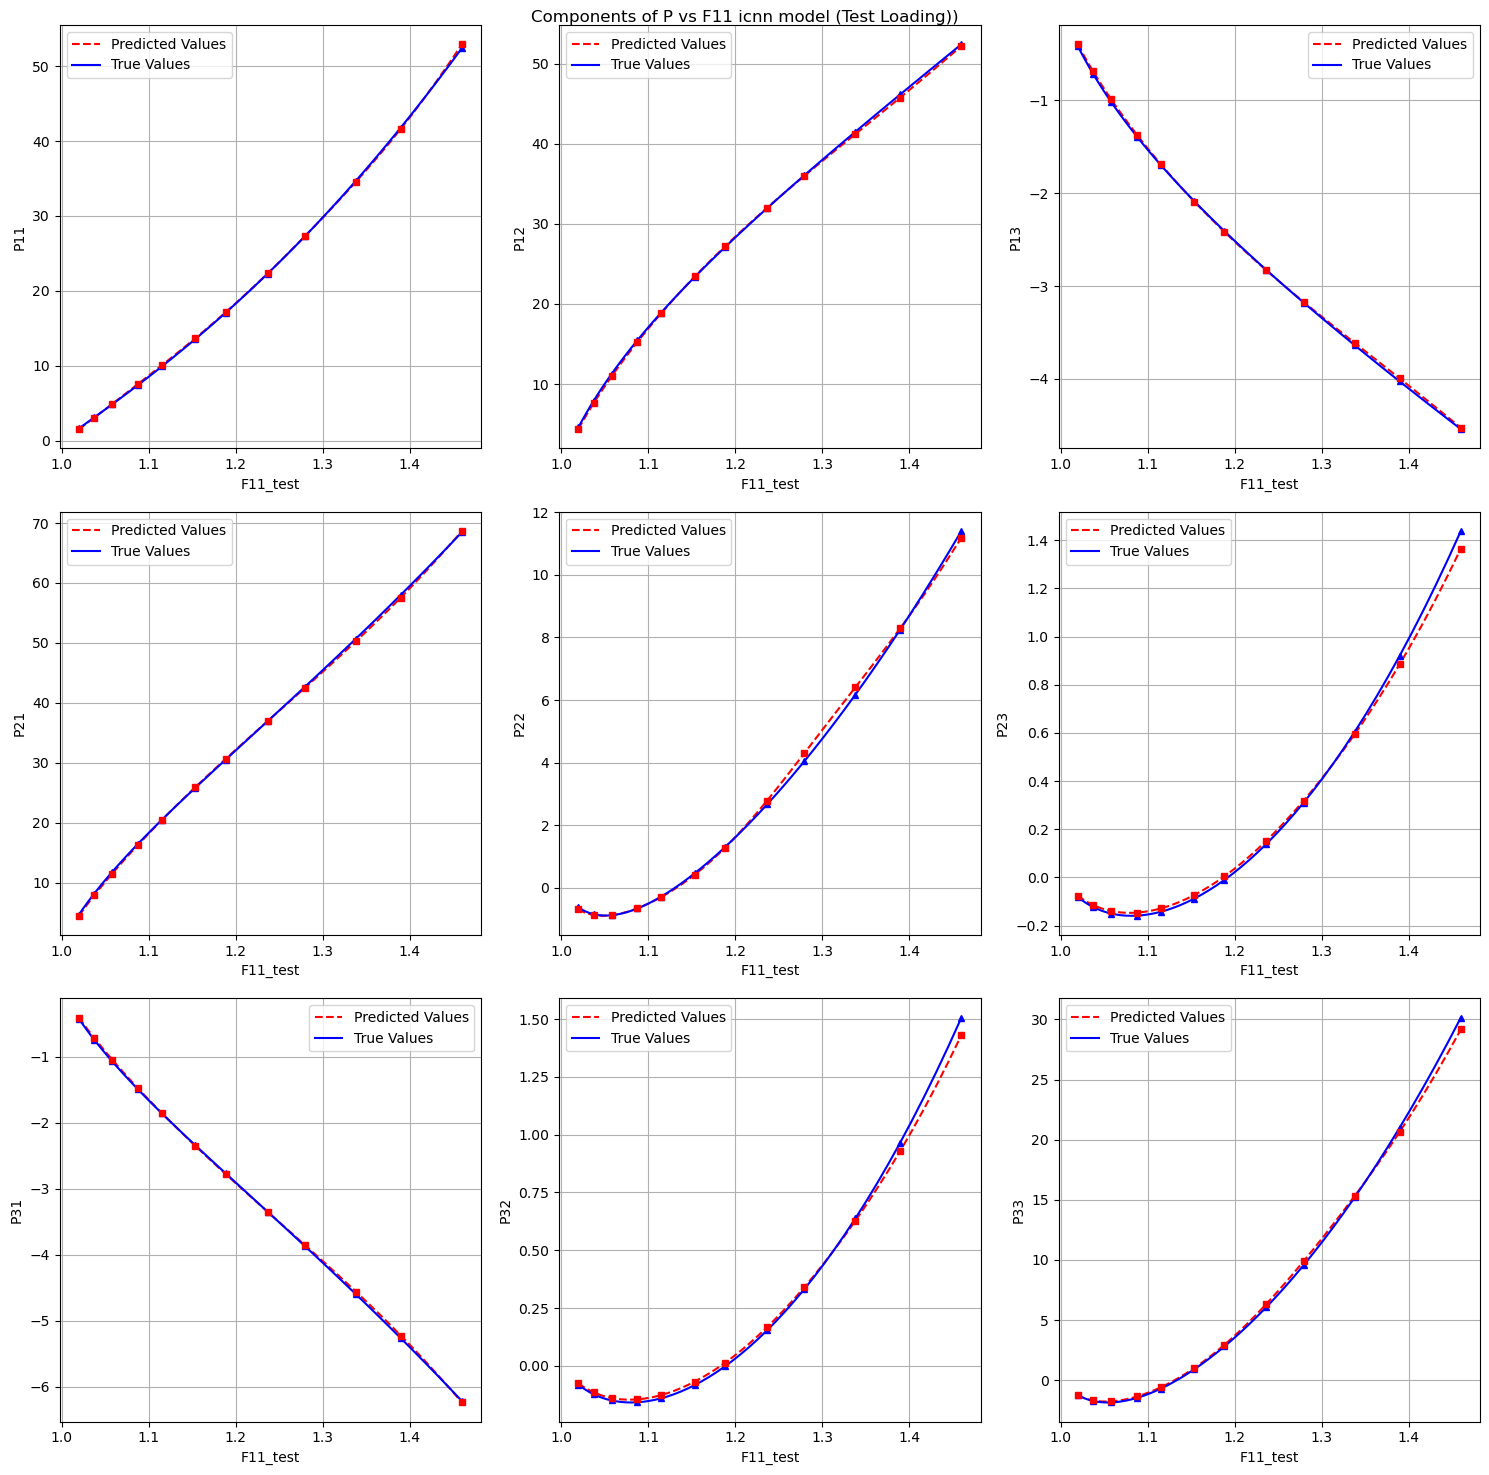

In [82]:
import matplotlib.pyplot as plt
import numpy as np

P_test_pred_A2_658 = P_test_pred_A2_658.numpy().reshape(-1, 3, 3)
F11_test = F_test[:, 0, 0]

# Select 12 evenly spaced indices
total_points = len(F11_test)
indices = np.linspace(0, total_points-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 icnn model (Test Loading))')

# Flatten the axs array for easier iteration
axs = axs.flatten()
P_test = P_test.reshape(-1, 3, 3)
# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_test, P_test_pred_A2_658[:, i, j], 'r--', label='Predicted Values')
        # Plot the continuous true values with solid blue line
        axs[index].plot(F11_test, P_test[:, i, j], 'b-', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_test[indices], P_test[indices, i, j], 'b-', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_test[indices], P_test_pred_A2_658[indices, i, j], 'r', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()
